## 라이브러리 import

In [56]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from urllib.parse import urlencode, quote_plus, unquote
import json
from urllib.request import *
from xml.etree.ElementTree import *
from math import *
import datetime
import pytz
import gmaps
import gmaps.datasets
import datetime
import time
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException

## 현재 위치 가져오기

In [57]:
driver = webdriver.Chrome('chromedriver.exe')

def get_location():
    driver.get("https://www.google.co.kr/maps")
    new_url = driver.current_url
    while '/@' not in new_url:
        time.sleep(0.5)
        new_url = driver.current_url

    driver.find_element_by_xpath("//button[@aria-label='내 위치 보기']").click()
    while new_url == driver.current_url:
        time.sleep(0.3)
    new_url = driver.current_url

    while int(new_url.split("/@")[1].split("z")[0].split(",")[2]) < 20:
        old_url = new_url
        driver.find_element_by_xpath("//button[@aria-label='확대']").click()
        driver.implicitly_wait(3)
        while old_url == driver.current_url:
            time.sleep(0.3)
        new_url = driver.current_url
        print(new_url)
    coordinate = new_url.split('/@')[1].split(',')[0:2]

    driver.find_element_by_id("searchboxinput").send_keys(",".join(coordinate))
    driver.find_element_by_id("searchbox-searchbutton").click()
    driver.implicitly_wait(3)
    while True:
        time.sleep(0.5)
        new_url = driver.current_url
        print(new_url)
        if "search" in new_url:
            try:
                driver.find_element_by_class_name("section-result")
            except NoSuchElementException:
                print("redirecting")
        elif "place" in new_url:
            try:
                place = driver.find_element_by_xpath("//span[@class='widget-pane-link']")
            except NoSuchElementException:
                print("loading")
                time.sleep(0.2)
            else:
                break
    coordinate.reverse()
    address = place.text.split(' ')
    for s in address:
        if s[-1] == '구':
            coordinate.append(s)
            break

    return coordinate

In [58]:
Current_location = get_location()
driver.close()

https://www.google.co.kr/maps/@37.5505441,127.0722199,14z
https://www.google.co.kr/maps/@37.5505441,127.0722199,15z
https://www.google.co.kr/maps/@37.5505441,127.0722199,16z
https://www.google.co.kr/maps/@37.5505441,127.0722199,17z
https://www.google.co.kr/maps/@37.5505441,127.0722199,18z
https://www.google.co.kr/maps/@37.5505441,127.0722199,19z
https://www.google.co.kr/maps/@37.5505441,127.0722199,20z
https://www.google.co.kr/maps/search/37.5505441,127.0722199/@37.5505441,127.0722199,20z
redirecting
https://www.google.co.kr/maps/search/37.5505441,127.0722199/@37.5505441,127.0722199,20z
redirecting
https://www.google.co.kr/maps/place/37%C2%B033'02.0%22N+127%C2%B004'20.0%22E/@37.5505441,127.0716727,19z/data=!3m1!4b1!4m5!3m4!1s0x0:0x0!8m2!3d37.5505441!4d127.0722199


In [59]:
Longitude, Latitude, stationName = Current_location
Longitude, Latitude = float(Longitude), float(Latitude)

## 날씨 가져오는 함수들

In [1]:
def get_weather_data(longi, latit, key="...."):
    grib_date, grib_time = get_grib_date()
    grib_url = "http://newsky2.kma.go.kr/service/SecndSrtpdFrcstInfoService2/ForecastGrib?"
    forecast_date, forecast_time = get_forecast_date()
    forecast_url = "http://newsky2.kma.go.kr/service/SecndSrtpdFrcstInfoService2/ForecastTimeData?"
    nx, ny = longitude_and_latitude_to_cartesian(longi, latit)

    grib = urlopen(grib_url+"serviceKey="+key+"&base_date="+grib_date+"&base_time="+grib_time+"&nx="+nx+"&ny="+ny).read().decode("utf-8")
    forecast = urlopen(forecast_url+"serviceKey="+key+"&base_date="+forecast_date+"&base_time="+forecast_time+"&nx="+nx+"&ny="+ny).read().decode("utf-8")

    grib_data = fromstring(grib)  # 초단기 실황
    forecast_data = fromstring(forecast)  # 초단기 예보
    # 초단기 날씨 상황에는 정보 누락이 있을 수 있음

    data_parsed = {"T1H":"None", "RN1":"None", "PTY":"None", "SKY":"None", "LGT":"None", "WSD":"None"}
    for item in forecast_data[1][0]:
        if item[2].text in list(data_parsed.keys()):
            data_parsed[item[2].text] = item[5].text
    for item in grib_data[1][0]:
        if item[2].text in list(data_parsed.keys()):
            data_parsed[item[2].text] = item[5].text

    return data_parsed

In [61]:
def get_grib_date():
    now = datetime.datetime.now(tz=pytz.timezone("Asia/Seoul"))
    date_now = now.strftime("%Y%m%d")
    time_now = now.strftime("%H") + "00"

    return date_now, time_now

In [62]:
def get_forecast_date():
    now = datetime.datetime.now(tz=pytz.timezone("Asia/Seoul"))
    min_chk = datetime.datetime.now(tz=pytz.timezone("Asia/Seoul")).strftime("%M")

    if int(min_chk) < 30:
        now -= datetime.timedelta(hours=1)
    date_now = now.strftime("%Y%m%d")
    time_now = now.strftime("%H") + "30"

    return date_now, time_now

In [63]:
def longitude_and_latitude_to_cartesian(longitude, latitude):
    lon = float(longitude)
    lat = float(latitude)

    _Re = 6371.00877
    _grid = 5
    _slat1 = 30
    _slat2 = 60
    _olon = 126
    _olat = 38
    _xo = 210 / _grid
    _yo = 675 / _grid

    DEGRAD = pi / 180.0
    RADDEG = 180.0 / pi

    re = _Re / _grid
    slat1 = _slat1 * DEGRAD
    slat2 = _slat2 * DEGRAD
    olon = _olon * DEGRAD
    olat = _olat * DEGRAD

    sn = tan(pi * 0.25 + slat2 * 0.5) / tan(pi * 0.25 + slat1 * 0.5)
    sn = log(cos(slat1) / cos(slat2)) / log(sn)
    sf = tan(pi * 0.25 + slat1 * 0.5)
    tmp = sf ** sn if sf > 0 else -(abs(sf) ** sn)
    sf = tmp * cos(slat1) / sn
    ro = tan(pi * 0.25 + olat * 0.5)
    ro = re * sf / (ro ** sn if ro > 0 else -(abs(ro) ** sn))

    ra = tan(pi * 0.25 + lat * DEGRAD * 0.5)
    ra = re * sf / (ra ** sn if ra > 0 else -(abs(ra) ** sn))
    theta = lon * DEGRAD - olon
    if theta > pi:
        theta -= 2.0 * pi
    if theta < -pi:
        theta += 2.0 * pi
    theta *= sn
    x = ra * sin(theta) + _xo
    y = (ro - ra * cos(theta)) + _yo

    return str(int(x+1.5)), str(int(y+1.5))

## 미세먼지 가져오기

In [2]:
url = 'http://openapi.airkorea.or.kr/openapi/services/rest/ArpltnInforInqireSvc/getMsrstnAcctoRltmMesureDnsty'
service_key = '....' # FIXME
stationName = stationName

NameError: name 'stationName' is not defined

In [65]:
def get_fine_dict_data(service_key, stationName):
    decode_key = unquote(service_key)
    queryParams = '?' + urlencode({ quote_plus('ServiceKey') : decode_key, quote_plus('stationName'): stationName, quote_plus('dataTerm'): 'daily', quote_plus('_returnType'): 'json', quote_plus('ver'): '1.3', quote_plus('pageNo'): 1})

    request = Request(url + queryParams)
    request.get_method = lambda: 'GET'
    response_body = urlopen(request).read()
    response_body = json.loads(response_body)
    return  response_body['list'][0]['pm10Grade'],response_body['list'][0]['pm25Grade'],  response_body['list'][0]['dataTime']

### 날씨 및 미세먼지 변수만들기

In [66]:
weather_dict = get_weather_data(Longitude, Latitude)
fine_dust, Ultrafine_dust, dataTime = get_fine_dict_data(service_key, stationName)

### 날씨 : weather_dict , 미세먼지 : fine_dust , 초미세먼지 : Ultrafine_dust , 미세먼지 시간 : dataTime

#### weather_dict
    # | 등급	| 좋음 | 보통 |	나쁨 | 매우나쁨 |  
    # | Grade |	 1   |	2   |	3  |    4     |

#### fine_dust
    # T1H : 기온
    # RN1 : 1시간 강수량
    #       (0 - 0mm 또는 없음)
    #       (1 - 1mm 미만)
    #       (5 - 1~4mm)
    #       (10 - 5~9mm)
    #       (20 - 10~19mm)
    #       (40 - 20~39mm)
    #       (70 - 40~69mm)
    #       (100 - 70mm 이상)
    # PTY : 강수형태 -- 0 - 없음 , 1 - 비 , 2 - 진눈깨비 , 3 - 눈
    # SKY : 하늘상태 -- 1 - 맑음 , 2 - 구름조금 , 3 - 구름많음 , 4 - 흐림
    # LGT : 낙뢰 -- 0 - 없음 , 1 - 있음
    #          또는 0 - 없음 , 1 - 낮음 , 2 - 보통 , 3 - 높음
    # WSD : 풍속

### 데이터 보기

In [67]:
df = pd.read_csv("Seoul_Place.csv")

# MAIN CODE

In [68]:
t = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tt = datetime.datetime.now()
n = time.localtime().tm_wday

## Open시간 필터링

In [69]:
#Find_Hours_of_use("10AM-11PM")

In [70]:
def Find_Hours_of_use(zz):
    p1 = re.compile('(AM)+')
    m1 = p1.search(zz)
    p2 = re.compile('(PM)+')
    m2 = p2.search(zz)
    p3 = re.compile('(:)+')
    m3 = p3.search(zz)
    p5 = re.compile('(-)+')
    m5 = p5.search(zz)
    #print(zz)

    i11 = int(re.findall('\d+', str(m1))[0])
    i12 = int(re.findall('\d+', str(m1))[1])
    i21 = int(re.findall('\d+', str(m2))[0])
    i22 = int(re.findall('\d+', str(m2))[1])
    i51 = int(re.findall('\d+', str(m5))[0])
    i52 = int(re.findall('\d+', str(m5))[1])
    if(m3):
        i31 = int(re.findall('\d+', str(m3))[0])
        i32 = int(re.findall('\d+', str(m3))[1])
        z2=zz
        if(i31<i51):
            z2 = zz[i32:]
        p4 = re.compile('(:)+')
        m4 = p4.search(z2)
        if(m4):
            i41 = int(re.findall('\d+', str(m4))[0])
            i42 = int(re.findall('\d+', str(m4))[1])
            p5 = re.compile('(-)+')
            m5 = p5.search(z2)
        else:
            i41 = None
            i42 = None
    else:
        i31 = None
        i32 = None
        z2 = None
        i41 = None
        i42 = None

    i51 = int(re.findall('\d+', str(m5))[0])
    i52 = int(re.findall('\d+', str(m5))[1])
    
    if (i31 and i31<i51):
        openss = zz[:i11]
        opensss = int(openss[:i31])*60 + int(openss[i32:])
    else:
        opensss = int(zz[:i11])*60 

    if i41:
        closs = z2[i52:]
        i41 -= len(z2)-len(closs)
        i42 -= len(z2)-len(closs)
        closss = int(closs[:i41])*60 + int(closs[i42:-2])
    else:
        closss = int(zz[i52:-2])*60

    return opensss,closss+12*60

In [71]:
def Make_Hours_of_use(timessss,p):
    
    ##########################
    #if(timessss in cp):
    #    return -1
    ##########################
    
    if(timessss!="Open 24 hours" and timessss!="Closed"):
        return (Find_Hours_of_use(timessss)[p])
    elif(timessss=="Open 24 hours"):
        return (p*24*60)
    elif(timessss=="Closed"):
        return (-1)

In [72]:
opentime=[]
closetime=[]
for dftn in df[t[n]]:
    opentime.append(Make_Hours_of_use(dftn,0))
    closetime.append(Make_Hours_of_use(dftn,1))

In [73]:
df["opentime"]=opentime
df["closetime"]=closetime

In [74]:
now = tt.hour*60 + tt.minute

In [75]:
df= df[(df["opentime"]<now) & (now<df["closetime"])]

## 날씨 필터링

In [76]:
try:
    fine_dust = int(fine_dust)
except:
    fine_dust=0
try: 
    Ultrafine_dust= int(Ultrafine_dust)
except:
    Ultrafine_dust= 0
try: 
    T1H = int(weather_dict["T1H"])
except:
    T1H=0
try: 
    RN1 = float(weather_dict["RN1"])
except:
    RN1=0
try: 
    PTY = int(weather_dict["PTY"])
except:
    PTY = 0
try:
    SKY = int(weather_dict["SKY"])
except:
    SKY = 0
try: 
    LGT = int(weather_dict["LGT"])
except:
    LGT = 0
try: 
    WSD = int(weather_dict["WSD"])
except:
    WSD = 0

In [77]:
if (fine_dust>=3 or Ultrafine_dust>=3 or T1H<-5 or 30 <T1H or RN1>=1 or PTY>=1):
    df = df[df["Indoor/Outdoors"]!="Outdoor"]
    
if(fine_dust==4 or Ultrafine_dust==4 or LGT >=1 or WSD >=100or T1H<-15 or 37 <T1H or RN1>=10):
    df = df[df["Indoor/Outdoors"]=="Indoor"]

## 원하는 장소로 필터링

In [78]:
#1.음식 먹기
EatingFood = [
    '딤섬 전문 레스토랑',
    '음식점',
    '이탈리아 음식점',
    '일본 음식점',
    '중국 음식점',
    '패밀리 레스토랑',
    '프랑스 음식점',
    '한국식 소고기 전문 음식점',
    '한식 고기구이 레스토랑'
]

#2. 마시기 
Drinking = [ '바 & 그릴',
    '술집',
    '와인 바',
    '재즈바',
    '카페',
    '칵테일바',
]

#####

#3. 의미있는 곳
MeaningfulPlace = ['문화유산보존지역',
    '불교사찰',
    '성당',
    '역사유적지',
    '역사적 명소'
]

#4. 밖 인공,자연
Outdoors = ['고궁',
    '관광명소',
    '관광지',
    '다리',
    '대광장',
    '타워',
    '공원',
    '국립공원',
    '산'
]

#5. 앉아서 보고 듣기
SeeAndHear=['공연예술 극장',
    '극장',
    '영화관',
    '자동차극장'
]


#6. 구경하기 
Watch =['미술관',
    '박물관'
]

#7. 놀기
Play = ['노래방',
    '놀이공원'
]

#8. 쇼핑하기
Shopping=['쇼핑몰',
    '시가 전문점',
    '시장',
    '커피용품 판매점',
]

#9. 운동하기
Exercise = ['건강 센터',
    '스포츠 단지',
    '스포츠단지'
]

#10. 복지
Welfare =['문화센터',
    '정부청사'
]

### 원하는 장소들을 선택해서 필터링 진행

In [79]:
places = [EatingFood,Drinking,Watch]

In [128]:
def Hople_Places(place):
    hopedf =  df[df["Function"] == "Fsdfsd"]
    places = place
    for p in places:
        onehope = df[df["Function"] == p]
        hopedf = hopedf.append(onehope)
    
    return hopedf

In [131]:
def Make_Hope_Places(places):
    hopedf =  df[df["Function"] == "Fsdfsd"]
    for place in places:
        hdf = Hople_Places(place)
        hopedf = hopedf.append(hdf)
    return hopedf

In [133]:
hopedf = Make_Hope_Places(places)

In [134]:
df = hopedf

## 거리필터링

In [136]:
#위도의 1도간 거리는 114.6km이고 경도의 1도간 거리는 88km가 된다.  
def Longitude_Latitude_To_KM(num, clas):
    if(clas == "Latitude"): #위도
        return num * 114.6
    elif(clas == "Longitude"): #경도 
        return num * 88
    else:
        return 0

In [137]:
#위도의 1도간 거리는 114.6km이고 경도의 1도간 거리는 88km가 된다.  
def KM_To_Longitude_Latitude(num, clas):
    if(clas == "Latitude"): #위도
        return num / 114.6
    elif(clas == "Longitude"): #경도 
        return num / 88
    else:
        return 0

In [138]:
def Distance_filtering(df,lo,la,Odistance,Adistance):
    df1 =  df[(lo-Odistance <= df['Longitude'] ) & (df['Longitude'] <=lo+Odistance )]
    df2 = df1[(la-Adistance <= df['Latitude'] ) & (df['Latitude'] <=la+Adistance )]
    return df2

In [139]:
O = KM_To_Longitude_Latitude(1, "Longitude")
A = KM_To_Longitude_Latitude(1, "Latitude")

In [140]:
while 1:
    Fdf = Distance_filtering(df,Longitude,Latitude,O,A)
    if 10 > len(Fdf["Name"]):
        O+=0.1
        A+=0.02
    else:
        break

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [141]:
len(Fdf["Name"])

60

### 빈것들 0으로 채우기

In [143]:
Fdf = Fdf.fillna(0)

## Socre 계산

In [144]:
Score = list(Fdf["Score"])
while(1):
    try:
        Score.remove(0)
    except:
        break

### 초기화
    0점으로 즉 비여있는 값들을 제일 낮은 점수 -1로 바꾸기

In [145]:
zidx = Fdf[Fdf["Score"]==0].index.tolist() 
ms = min(Score)-1

for i in zidx:
    Fdf.loc[i,'Score'] = ms

### Score 거리 기반으로 변경

In [146]:
idx = Fdf.index.tolist()
for i in idx:
    Fdf.loc[i,'Score'] = Fdf.loc[i,'Score'] + (abs(Longitude - Fdf.loc[i,'Longitude'])) + (abs(Latitude - Fdf.loc[i,'Latitude']))

### Score 추출 및 확률화

In [147]:
roulette_dic = {}
for i in idx:
    roulette_dic[i] = Fdf.loc[i,'Score']

In [148]:
r_score_l = list(roulette_dic.values())
len(r_score_l), sum(r_score_l)

(60, 221.67534119999974)

In [149]:
for i,s in roulette_dic.items():
    roulette_dic[i]= s/sum(r_score_l)

In [150]:
r_index_l = list(roulette_dic)

### 최종 추천 장소 뽑기 및 출력

In [151]:
np.random.choice(r_index_l, p=list(roulette_dic.values()))

272

In [152]:
find_place_idx = np.random.choice(r_index_l, p=list(roulette_dic.values()))
find_place = Fdf.loc[find_place_idx]
find_place

Name                                                         모서리에커피집
Function                                                          카페
Indoor/Outdoors                                               Indoor
Details            로스터리 커피집, Cofffee brewing, 커피티백, 더치커피, 수제카라멜 &...
Monday                                                  11:30AM-10PM
Tuesday                                                 11:30AM-10PM
Wednesday                                               11:30AM-10PM
Thursday                                                11:30AM-10PM
Friday                                                  11:30AM-10PM
Saturday                                                11:30AM-10PM
Sunday                                                  11:30AM-10PM
Score                                                        4.60594
NumOfReviews                                                      13
Latitude                                                      37.546
Longitude                         

모서리에커피집
분류 :  카페


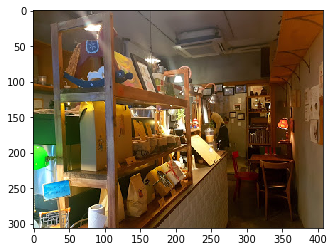

설명 :  로스터리 커피집, Cofffee brewing, 커피티백, 더치커피, 수제카라멜 & 다크초콜렛, 페이스텀블러, 그리고 쥔장의 소박한 일러스트들


In [153]:
print(find_place["Name"])
print("분류 : ",find_place["Function"])
img=mpimg.imread('image/'+find_place["Image"])
imgplot = plt.imshow(img)
plt.show()

print("설명 : ",find_place["Details"])